In [2]:
## import necessary libraries
import time
import datetime
import numpy as np
import cvxpy as cp
from utils.synth import *
from utils.sim import *
from utils.competitors import *
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

In [3]:
T0 = 50
T1 = 5
J = 20
rho1, rho2 = 0, 0
threshold = 1e-4
optim = True
stationary = 0
# DGP = 10
trt_effect = 0

In [4]:
np.random.seed(12345)
T01 = T0 + T1
F1 = np.random.normal(scale = 5, size=T01)
F2 = np.random.normal(size=T01)
if not stationary:
    # F2 = np.random.normal(loc=np.arange(1, T01 + 1), 
    #                       scale=np.arange(1, T01 + 1))
    F2 += np.arange(1, T01 + 1)

lambda1 = np.arange(1, J + 1) / J
lambda2 = lambda1.copy()
# lambda2 = np.arange(1, J + 1) 

w = np.array([-0.1, 0, 0, -0.02, 0,
             -0.1, -0.2, -0.1, 0, 0,
             0, 0.37, 0, 0, 0.25,
             -0.5, 0.7, 0, -0.1, 0.33])
# w = np.random.uniform(low=-1/J, high=4/J, size=J)

print(w.flatten())
y = np.kron(np.ones(T01), lambda1) + np.kron(F1, np.ones(J)) + \
    np.kron(F2, lambda2)

eps = np.empty((T01, J))
for j in range(J):
    eps[:, j] = generate_AR_series(T01, rho1)

Y0 = y.reshape(T01, J) + eps
u = generate_AR_series(T01, rho2)
Y1 = Y0 @ w + u.reshape(-1, 1)
Y1 = Y1.flatten()
Y1[T0:] += trt_effect

Y0_pre = Y0[:T0,:]
Y0_post = Y0[T0:,:]
Y1_pre = Y1[:T0]
Y1_post = Y1[T0:]

idxs = np.random.choice(T0, T0, replace=False)
idxs1, idxs2 = idxs[:T0//2], idxs[T0//2:]
# np.savetxt("pre_data.csv", np.hstack([Y1_pre.reshape(-1, 1), Y0_pre]), delimiter=",", comments='')
np.savetxt("pre_data1.csv", np.hstack([Y1_pre[idxs1].reshape(-1, 1), Y0_pre[idxs1]]), delimiter=",", comments='')
np.savetxt("pre_data2.csv", np.hstack([Y1_pre[idxs2].reshape(-1, 1), Y0_pre[idxs2]]), delimiter=",", comments='')
np.savetxt("w.csv", w, delimiter=",", comments='')
np.set_printoptions(suppress=True)

[-0.1   0.    0.   -0.02  0.   -0.1  -0.2  -0.1   0.    0.    0.    0.37
  0.    0.    0.25 -0.5   0.7   0.   -0.1   0.33]


In [5]:
K_list = np.linspace(0.0, 5.0, num=50)  # Alpha values including 0
sspe_list = np.zeros_like(K_list)
for method in ['l1', 'l2', 'inf', 'l1-l2', 'l1-inf']:
    for i in range(len(K_list)):
        sspe_list[i] = compute_param_iteration(Y1_pre, Y0_pre, method, alpha=.5, K=K_list[i])
    
    plt.figure(figsize=(5, 5))
    plt.plot(K_list, sspe_list)
    plt.xlabel('lambda')
    plt.ylabel('SSPE')
    plt.title(f'{method}')
    plt.savefig(f'{method}.png')
    plt.close()

TypeError: compute_param_iteration() got an unexpected keyword argument 'K'

In [ ]:
## compare the difference between the old and new methods
alpha = 0.1
K = 0.1
method = 'l2'
# w1 = solve_w_old(Y1_pre, Y0_pre, alpha, K, method, 'GUROBI')
w2 = our(Y1_pre[idxs2], Y0_pre[idxs2], alpha, K, method)
# Y0_pre_plus = np.hstack([np.ones((Y1_pre.shape[0], 1)), Y0_pre])
# print(w1)
print(w2[1:] - w)
# print((Y1_pre - Y0_pre_plus @ w1) @ (Y1_pre - Y0_pre_plus @ w1))
# print((Y1_pre - Y0_pre_plus @ w2) @ (Y1_pre - Y0_pre_plus @ w2))

[ 1.22485257e-04  1.49037321e-04 -2.05410048e-04  8.54981277e-06
 -2.63141995e-04 -1.89956879e-04  1.00262577e-04 -1.63512376e-05
  1.74259247e-04  4.75234102e-05]


In [ ]:
alpha = 1.0
num = 50
K_list = np.linspace(3, 0.0, num=num)
K_list_sum = np.linspace(4, 1/J, num=num)

W_l1 = np.zeros([num, J+1])
W_l2 = W_l1.copy()
W_inf = W_l1.copy()
W_sum_inf = W_l1.copy()
W_sum_l2 = W_l1.copy()
W_l1_l2 = W_l1.copy()
W_l1_inf = W_l1.copy()


start_time = time.time()  # Start time
for i in range(num):
    
    W_l1[i, :] = our(Y1_pre, Y0_pre, alpha, K_list[i], 'l1')
    W_l2[i, :] = our(Y1_pre, Y0_pre, alpha, K_list[i], 'l2')
    W_inf[i, :] = our(Y1_pre, Y0_pre, alpha, K_list[i], 'inf')
    W_l1_l2[i, :] = our(Y1_pre, Y0_pre, alpha_l1_l2, K_list[i], 'l1-l2')
    W_l1_inf[i, :] = our(Y1_pre, Y0_pre, alpha_l1_inf, K_list[i], 'l1-inf')
    # W_sum_l2[i, :] = our(Y1_pre, Y0_pre, alpha, K_list_sum[i], 'sum-l2')
    # W_sum_inf[i, :] = our(Y1_pre, Y0_pre, alpha, K_list_sum[i], 'sum-inf')
    
end_time = time.time()  # End time
elapsed_time = end_time - start_time
formatted_time = str(datetime.timedelta(seconds=elapsed_time))
print(f"The code took {formatted_time} to run (h:mm:ss).")

# Stack the matrices
stacked_matrices = np.stack((W_l1[:,1:], W_l2[:,1:], W_inf[:,1:], W_l1_l2[:,1:], W_l1_inf[:,1:]))
# Compute the absolute values for the entire stack
abs_stacked = np.abs(stacked_matrices)
# Find the largest absolute value across all matrices
axis_val = np.max(abs_stacked)

plt.figure()
plt.plot(K_list, W_l1[:,1:])
plt.title('L1 norm')
plt.xlabel('K')
plt.ylabel('weight')
plt.ylim((-axis_val,axis_val))
# plt.xscale('log')
plt.savefig(f'graphics/fig1.png')
plt.close()

plt.figure()
plt.plot(K_list, W_l2[:,1:])
plt.title('L2 norm')
plt.xlabel('K')
plt.ylabel('weight')
plt.ylim((-axis_val,axis_val))
# plt.xscale('log')
plt.savefig(f'graphics/fig2.png')
plt.close()

plt.figure()
plt.plot(K_list, W_inf[:,1:])
plt.title('L-inf norm')
plt.xlabel('K')
plt.ylabel('weight')
plt.ylim((-axis_val,axis_val))
# plt.xscale('log')
plt.savefig(f'graphics/fig3.png')
plt.close()

plt.figure()
plt.plot(K_list, W_l1_l2[:,1:])
plt.title('L1 + L2')
plt.xlabel('K')
plt.ylabel('weight')
plt.ylim((-axis_val,axis_val))
# plt.xscale('log')
plt.savefig(f'graphics/alpha_{alpha_l1_l2:.2f}_fig4.png')
plt.close()

plt.figure()
plt.plot(K_list, W_l1_inf[:,1:])
plt.title('L1 + L-inf')
plt.xlabel('K')
plt.ylabel('weight')
plt.ylim((-axis_val,axis_val))
# plt.xscale('log')
plt.savefig(f'graphics/alpha_{alpha_l1_inf:.2f}_fig5.png')
plt.close()

# plt.figure()
# plt.plot(K_list_sum, W_sum_l2[:,1:])
# plt.title('s-constr + L2')
# plt.xlabel('K')
# plt.ylabel('weight')
# plt.ylim((-axis_val,axis_val))
# # plt.xscale('log')
# plt.savefig(f'graphics/new_fig6.png')
# plt.close()

# plt.figure()
# plt.plot(K_list_sum, W_sum_inf[:,1:])
# plt.title('s-constr + L-inf')
# plt.xlabel('K')
# plt.ylabel('weight')
# plt.ylim((-axis_val,axis_val))
# # plt.xscale('log')
# plt.savefig(f'graphics/new_fig7.png')
# plt.close()

The code took 0:00:00.312092 to run (h:mm:ss).


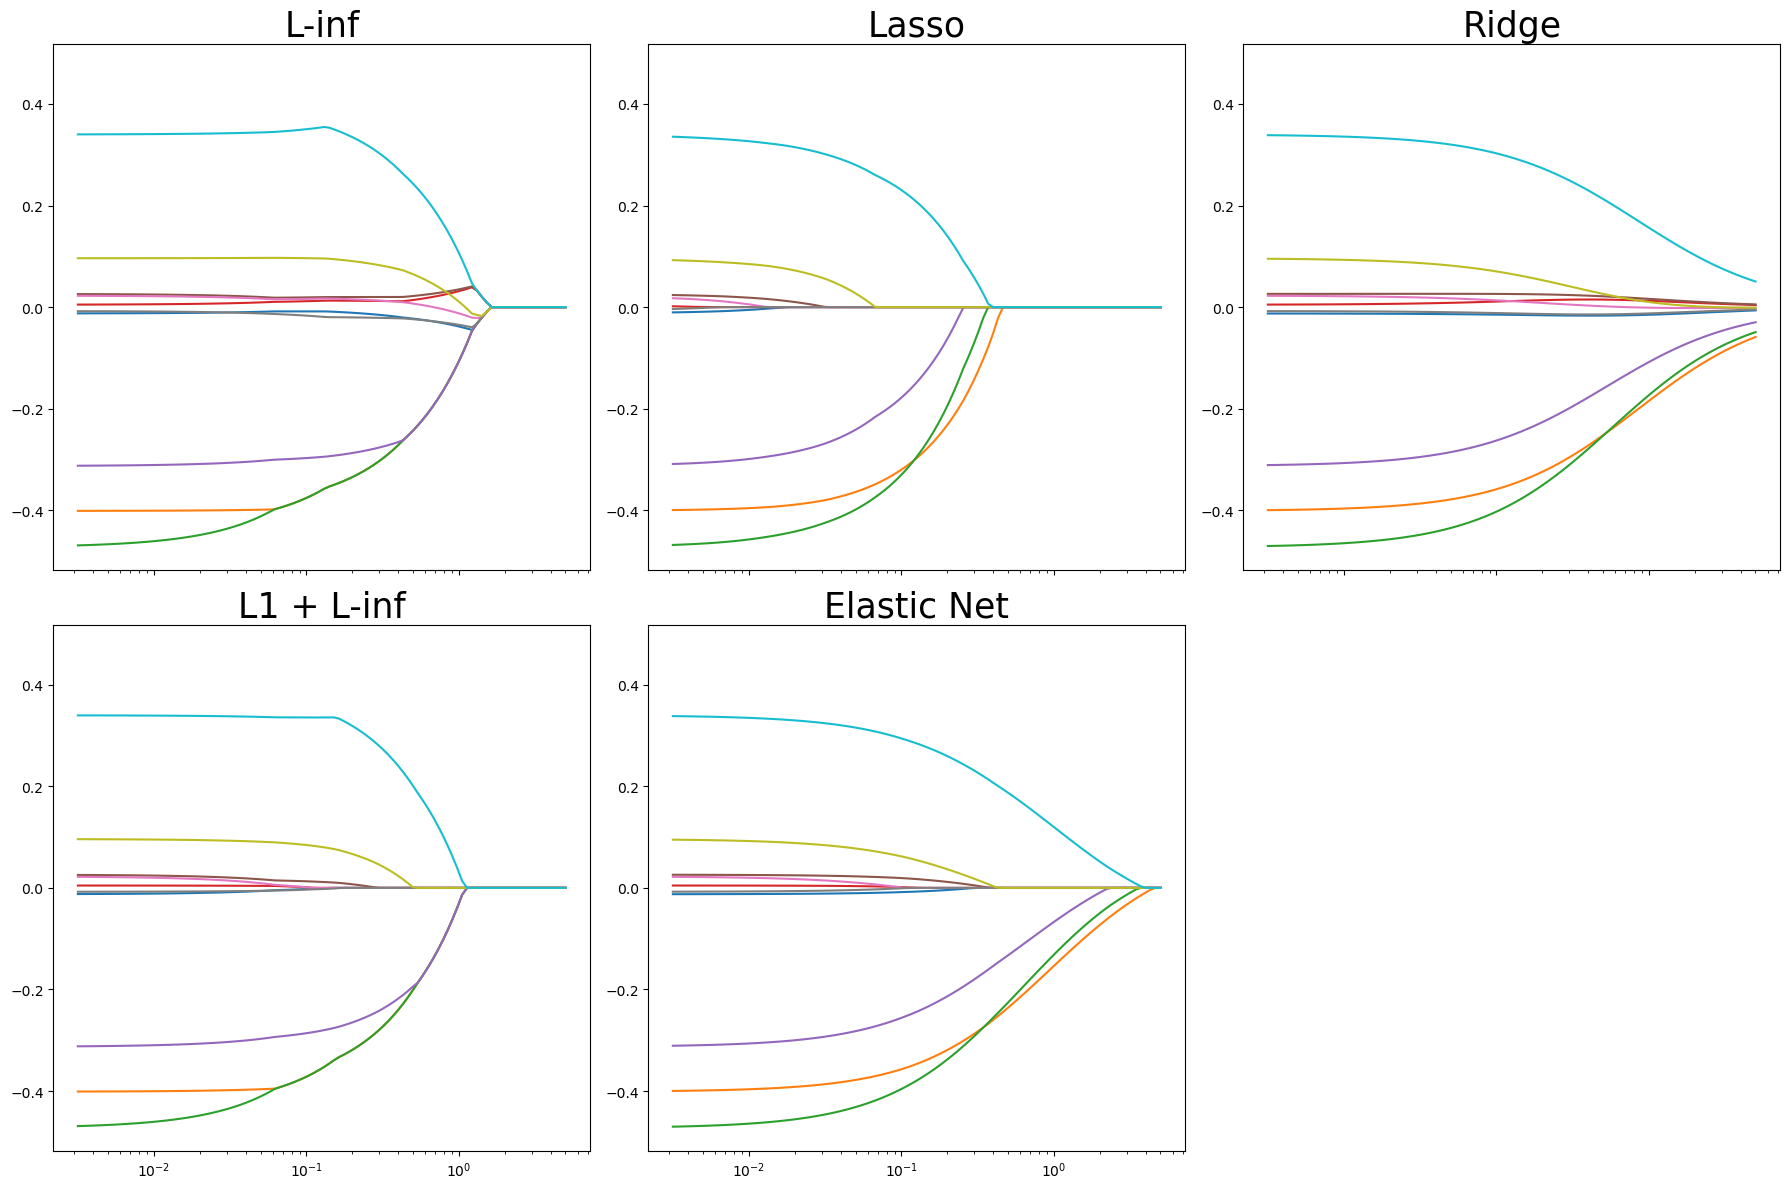

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from utils.synth import our  # Assuming this function is still available

# Set random seed for reproducibility
np.random.seed(45)

# Simulation parameters
T0 = 100  # Pre-intervention periods
J = 10    # Number of control units
J_nonzero = 5

# Generate true weights with sparsity
w_true = np.zeros(J)
non_zero_indices = np.random.choice(J, size=J_nonzero, replace=False)  # non-zero weights
w_true[non_zero_indices] = np.random.uniform(-0.5, 0.5, size=J_nonzero)
# w_true /= w_true.sum()  # Normalize weights to sum to 1

# Generate control unit data
Y0_pre = np.random.randn(T0, J)

# Generate treated unit data
u = np.random.normal(0, 0.2, T0)  # Noise term
Y1_pre = Y0_pre @ w_true.reshape(-1, 1) + u.reshape(-1, 1)
Y1_pre = Y1_pre.flatten()

def compute_solution_path(Y1_pre, Y0_pre, method, lambda_range):
    weights = []
    for lam in lambda_range:
        w = our(Y1_pre, Y0_pre, 0.1, lam, method)
        weights.append(w[1:])  # Exclude the intercept
    return np.array(weights)

# Define lambda ranges
lambda_range = np.logspace(-2.5, .7, 100)

# Compute solution paths for each method
methods = ['inf', 'l1', 'l2', 'l1-inf', 'l1-l2']
titles = ['L-inf', 'Lasso', 'Ridge', 'L1 + L-inf', 'Elastic Net']
solution_paths = {}

for method in methods:
    solution_paths[method] = compute_solution_path(Y1_pre, Y0_pre, method, lambda_range)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Calculate the maximum absolute value
all_weights = np.concatenate([weights for weights in solution_paths.values()])
max_abs_value = max(np.abs(all_weights).max(), np.abs(w_true).max())

# Add some padding to the limit
padding = max_abs_value * 0.1
axis_limit = max_abs_value + padding

for idx, (method, weights) in enumerate(solution_paths.items()):
    ax = axes[idx]
    for j in range(weights.shape[1]):
        ax.plot(lambda_range, weights[:, j], label=f'Weight {j+1}')
    ax.set_xscale('log')
    # ax.set_xlabel('Lambda', fontsize=16)
    # ax.set_ylabel('Weight', fontsize=16)
    ax.set_title(f'{titles[idx]}', fontsize=25)
    # ax.grid(True)


    # Set the same y-axis limits for all subplots
    ax.set_ylim(-axis_limit, axis_limit)

    ax.tick_params(axis='both', which='minor', labelsize=18)

# Remove the empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig("simulation_solution_paths.png", dpi=300)
plt.show()

# # Print the number of non-zero weights for each method at different lambda values
# lambda_points = [0.1, 1.0, 10.0]
# for method in methods:
#     print(f"\n{method} method:")
#     for lam in lambda_points:
#         idx = np.abs(lambda_range - lam).argmin()
#         non_zero = np.sum(np.abs(solution_paths[method][idx]) > 1e-6)
#         print(f"  Lambda = {lam:.1f}: {non_zero} non-zero weights")

# # Print true non-zero weights
# print("\nTrue non-zero weights:")
# for i, w in enumerate(w_true):
#     if w > 0:
#         print(f"  Weight {i+1}: {w:.4f}")